In [1]:
'''
Script to print data properties such as:
- FOV in pixels/mm
- Cell densities
'''

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import json
import numpy as np
from scipy.stats import linregress

from src.Segmentation3D import get_voxel_size_35mm
from src.HolomonitorFunctions import get_pixel_size
from src.FormatConversions import import_holomonitor_stack, import_tomocube_stack
from src.CellSegmentation import *
# from src.PlottingUtils import mean_dist
# from src.NewSrc import *

In [3]:
# Image resolution
pix_to_um = get_pixel_size()
vox_to_um = get_voxel_size_35mm()

print(f"Image resolution\nHolomonitor: {pix_to_um[0]:0.6f} x {pix_to_um[1]:0.6f}\nTomocube:    {vox_to_um[1]} x {vox_to_um[2]}\nRatio H to T:       {vox_to_um[1]/pix_to_um[0]:0.6f}")
print(f"\nRatio z to xy: {vox_to_um[1] / vox_to_um[0]:0.6f}")

Image resolution
Holomonitor: 0.553711 x 0.553711
Tomocube:    0.155433 x 0.155433
Ratio H to T:       0.280711

Ratio z to xy: 0.164141


In [4]:
pix_to_um[0]*200

110.7421875

In [5]:
files = ["../../data/Holomonitor/MDCK_01.03.2024/B2-5", 
         "../../data/Holomonitor/MDCK_19.03.2024/A1-9", 
         "../../data/Holomonitor/MDCK_19.03.2024/A1-12",
         "../../data/Holomonitor/MDCK_19.03.2024/A1-18", 
         "../../data/Holomonitor/MDCK_19.03.2024/B1-11",
         "../../data/Holomonitor/MDCK_16.05.2024/B1-9"]

holo_dict = {"files": files, 
        "fmin":[188, 1, 1, 130, 1, 1], 
        "fmax":[225, 181, 145, 181, 145, 145],
        "blur_factor":0.75}


json.dump(holo_dict, open("../../data/Holomonitor/settings.txt", "w"))

In [6]:
files = ["../../data/Tomocube/MDCK_10.02.2025/A2P1"]

dict = {"files": files, 
        "fmin":[1], 
        "fmax":[40],
        "blur_factor":0.95}


json.dump(dict, open("../../data/Tomocube/settings.txt", "w"))

In [7]:
# Import data
# Holomonitor
dataset = 1
fmin=holo_dict['fmin'][dataset]
fmax=holo_dict['fmax'][dataset]
holo_file = "A1-12"
holo_dir  = "../../data/Holomonitor/MDCK_19.03.2024/"
h_stack = import_holomonitor_stack(holo_dir, holo_file, f_min=fmin, f_max=fmax)

df = pd.read_csv(f"{holo_dir}{holo_file}/area_volume_filtered.csv")
conversion = pix_to_um

# # Tomocube
# tomo_dir  = "../../data/Tomocube/MDCK_10.02.2025/A2P1"
# tomo_file = "250210.113448.MDCK dynamics.001.MDCK B.A2"
# n_stack, h_stack = import_tomocube_stack(tomo_dir, tomo_file, vox_to_um[0], f_min=1)

# df = pd.read_csv(f"{tomo_dir}/area_volume_filtered.csv")
# conversion = vox_to_um

In [8]:
# Size of FOV
x_FOV = len(h_stack[0])*conversion[1]
y_FOV = len(h_stack[0,0])*conversion[1]
A_FOV = x_FOV * y_FOV * 1e-6

print(f"FOV:\n{x_FOV:2.0f}x{y_FOV:2.0f} µm² = {A_FOV:0.3f} mm²")
print(f"{len(h_stack[0]):2.0f}x{len(h_stack[0,0]):2.0f} pixels\n")

FOV:
559x561 µm² = 0.313 mm²
1009x1013 pixels



In [9]:
frame = 0
N0_cells = np.sum(df.frame==frame)
A0_cells = np.sum(df[df.frame==frame].A) * 1e-6

frame = fmax-fmin-1
Nf_cells = np.sum(df.frame==frame)
Af_cells = np.sum(df[df.frame==frame].A) * 1e-6

print(f"Number of cells:\n{N0_cells:0.0f}-{Nf_cells:0.0f} cells\n")
print(f"Cell density:\n{N0_cells / A0_cells:0.0f}-{Nf_cells / Af_cells:0.0f} cells/mm² ")

Number of cells:
439-0 cells

Cell density:
1629-nan cells/mm² 


/tmp/ipykernel_14223/2246965084.py:10: RuntimeWarning: invalid value encountered in scalar divide
  print(f"Cell density:\n{N0_cells / A0_cells:0.0f}-{Nf_cells / Af_cells:0.0f} cells/mm² ")


/tmp/ipykernel_14223/2911904262.py:3: RuntimeWarning: invalid value encountered in scalar divide
  density = [np.sum(df.frame==frame) / np.sum(df[df.frame==frame].A) * 1e6 for frame in range(max_frame)]


nan


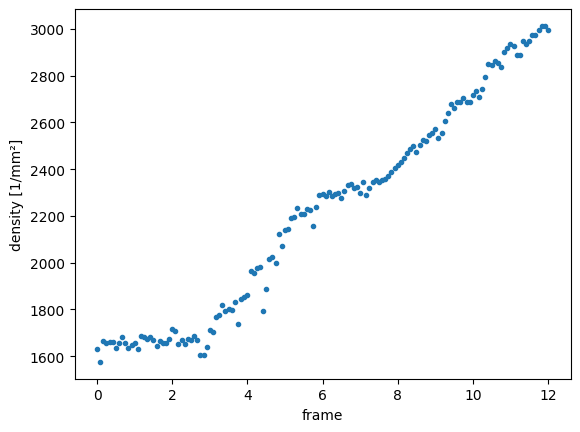

In [10]:
# plot evolution of density
max_frame = fmax-fmin
density = [np.sum(df.frame==frame) / np.sum(df[df.frame==frame].A) * 1e6 for frame in range(max_frame)]
n_cells = [np.sum(df.frame==frame) for frame in range(max_frame)]
frames = np.arange(max_frame)

plt.plot(frames/12, density, '.')
plt.xlabel("frame")
plt.ylabel("density [1/mm²]")

fit = linregress(frames, y=density)
lin_fit = fit.intercept + fit.slope*frames
plt.plot(frames/12, lin_fit, '--')

cell_fluct = np.std(density - lin_fit) / np.mean(density)
print(cell_fluct*100)

In [113]:
'''
1.6 %
2.7 %
3.5 %
2.3 %
2.1 %
2.5 %
1.5 %
'''

np.mean([1.6, 2.7, 3.5, 2.3, 2.1, 2.5, 1.5])

2.3142857142857145

In [60]:
frame = 18
N_cells = np.sum(df.frame==frame)
A_cells = np.sum(df[df.frame==frame].A) * 1e-6

print(f"IN FRAME {frame+1:0.0f}")
print(f"Total cell area:\n{A_cells:0.2f} mm², {A_cells /A_FOV:0.2f} of total FOV\n")
print(f"Number of cells:\n{N_cells:0.0f} cells\n")
print(f"Cell density:\n{N_cells / A_cells:0.2f} cells/mm² (cell area)\n{N_cells / A_FOV:0.2f} cells/mm² (total area)")

IN FRAME 19
Total cell area:
0.26 mm², 0.87 of total FOV

Number of cells:
503 cells

Cell density:
1920.61 cells/mm² (cell area)
1672.53 cells/mm² (total area)
